In [ ]:
import sys
!{sys.executable} -m pip install scikit-learn

## 6.3.1 2つの月のデータセット

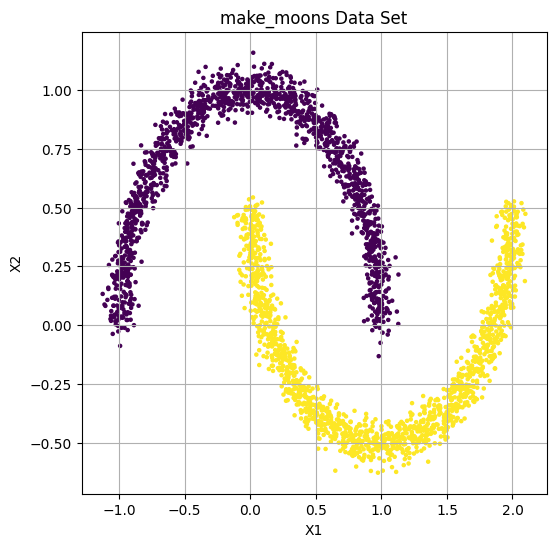

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=3000, noise=0.05)

plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis", s=5)
plt.title("make_moons Data Set")
plt.xlabel("X1")
plt.ylabel("X2")
plt.grid(True)
plt.show()

In [ ]:
import sklearn
from sklearn import datasets
import tensorflow as tf
from tensorflow.keras.layers import Normalization


data = datasets.make_moons(3_000, noise = 0.05)[0].astype("float32")
norm = Normalization()
norm.adapt(data)
normalized_data = norm(data)

## 6.3.2 カップリング層

In [ ]:
# Keras のカップリング層
def Coupling():
    input_layer = layers.Input(shape = 2)

    s_layer_1 = layers.Dense(
        256,
        activation         = "relu",
        kernel_regularizer = regularizers.l2(0.01)
    )(input_layer)

    s_layer_2 = layers.Dense(
        256,
        activation         = "relu",
        kernel_regularizer = regularizers.l2(0.01)
    )(s_layer_1)

    s_layer_3 = layers.Dense(
        256,
        activation         = "relu",
        kernel_regularizer = regularizers.l2(0.01)
    )(s_layer_2)

    s_layer_4 = layers.Dense(
        256,
        activation         = "relu",
        kernel_regularizer = regularizers.l2(0.01)
    )(s_layer_3)

    s_layer_5 = layers.Dense(
        256,
        activation         = "tanh",
        kernel_regularizer = regularizers.l2(0.01)
    )(s_layer_4)

    t_layer_1 = layers.Dense(
        256,
        activation         = "relu",
        kernel_regularizer = regularizers.l2(0.01)
    )(input_layer)

    t_layer_2 = layers.Dense(
        256,
        activation         = "relu",
        kernel_regularizer = regularizers.l2(0.01)
    )(t_layer_1)

    t_layer_3 = layers.Dense(
        256,
        activation         = "relu",
        kernel_regularizer = regularizers.l2(0.01)
    )(t_layer_2)

    t_layer_4 = layers.Dense(
        256,
        activation         = "relu",
        kernel_regularizer = regularizers.l2(0.01)
    )(t_layer_3)

    t_layer_5 = layers.Dense(
        256,
        activation         = "linear", # 線形関数
        kernel_regularizer = regularizers.l2(0.01)
    )(t_layer_4)

    return models.Model(inputs = input_layer, outputs = [s_layer_5, t_layer_5])

$$
tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}
$$

### 6.3.2.1 カップリング層にデータを渡す

### 6.3.2.2 カップリング層を積み重ねる

- 問題：入力の最初の d 個の要素をどのように更新すればよいか？
- 解決：ある層によって変更されなかった次元も、マスキングパターンを変えてカップリング層を積み重ねると次の層では更新される
    - 付加的な利点：ニューラルネットワークが深くなるため、より複雑な表現を学習できる

- **Jacobi 行列は簡単なまま**
    - ∵ 行列の積の行列式 = 各行列の行列式の積
$$
det(A \cdot B) = det(A) det(B)
$$
- **合成関数の逆関数 = 逆関数の合成関数**
$$
(f_b \circ f_a) = f_a^{-1} \circ f_b^{-1}
$$

## 6.3.3 Real NVP モデルを訓練する

- 目的：生成されたデータの負の対数尤度を最小化すること

- 式 6-1
$$
p_X(x) = p_Z(z) \left| { det \left( \frac{\partial z}{\partial x} \right) } \right|
$$

- を用いると
$$
-\log{p_X(x)} = -\log{p_Z(x)} - \log{\left| { det \left( \frac{\partial z}{\partial x} \right) } \right|}
$$

In [ ]:
from tensorflow.keras import layers, models, regularizers

class Coupling(layers.Layer):
    def __init__(self, input_dim, hidden_dim, regularization):
        super().__init__()
        self.s_net = models.Sequential([
            layers.Input(shape=(input_dim,)),
            layers.Dense(hidden_dim, activation="relu", kernel_regularizer=regularizers.l2(regularization)),
            layers.Dense(hidden_dim, activation="relu", kernel_regularizer=regularizers.l2(regularization)),
            layers.Dense(hidden_dim, activation="relu", kernel_regularizer=regularizers.l2(regularization)),
            layers.Dense(hidden_dim, activation="relu", kernel_regularizer=regularizers.l2(regularization)),
            layers.Dense(input_dim, activation="tanh", kernel_regularizer=regularizers.l2(regularization)),
        ])
        self.t_net = models.Sequential([
            layers.Input(shape=(input_dim,)),
            layers.Dense(hidden_dim, activation="relu", kernel_regularizer=regularizers.l2(regularization)),
            layers.Dense(hidden_dim, activation="relu", kernel_regularizer=regularizers.l2(regularization)),
            layers.Dense(hidden_dim, activation="relu", kernel_regularizer=regularizers.l2(regularization)),
            layers.Dense(hidden_dim, activation="relu", kernel_regularizer=regularizers.l2(regularization)),
            layers.Dense(input_dim, activation="linear", kernel_regularizer=regularizers.l2(regularization)),
        ])

    def call(self, x):
        s = self.s_net(x)
        t = self.t_net(x)
        return s, t


In [ ]:
# Keras の Model をカスタマイズして Real NVP ネットワークを作成する

from tensorflow.keras import models, layers, regularizers, metrics, optimizers
import tensorflow_probability as tfp
import numpy as np

class RealNVP(models.Model):
    def __init__(
        self,
        input_dim,
        coupling_layers,
        coupling_dim,
        regularization
    ):
        super(RealNVP, self).__init__()
        self.coupling_layers = coupling_layers
        self.distribution = tfp.distributions.MultivariateNormalDiag(
            loc        = [0.0, 0.0],
            scale_diag = [1.0, 1.0]
        )
        self.masks = np.array(
            [ [0, 1], [1, 0] ] * (coupling_layers // 2),
            dtype = "float32"
        )
        self.loss_tracker = metrics.Mean(name = "loss")
        self.layers_list = [
            Coupling(input_dim, coupling_dim, regularization)
            for _ in range(coupling_layers)
        ]
    @property
    def metrics(self):
        return [self.loss_tracker]

    def call(self, x, training = True):
        log_det_inv = 0
        direction   = 1
        if training:
            direction = -1
        for i in range(self.coupling_layers)[::direction]: # ::1なら順方向 / ::-1 なら逆方向
            x_masked      = x * self.masks[i]
            reversed_mask = 1 - self.masks[i]
            s, t          = self.layers_list[i](x_masked)
            s            *= reversed_mask # s = s * reversed_mask
            t            *= reversed_mask # t = t * reversed_mask
            gate          = ( direction - 1 ) / 2
            x             = (
                            reversed_mask * (
                                x * tf.exp(direction * s)
                                + direction * t * tf.exp(gate * s)
                                            )

                            )
            log_det_inv  += gate * tf.reduce_sum(s, axis = 1)
        return x, log_det_inv

    def log_loss(self, x):
        y, logdet      = self(x)
        log_likelihood = self.distribution.log_prob(y) + logdet
        return -tf.reduce_mean(log_likelihood)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self.log_loss(data)
        g = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(g, self.trainable_variables))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self.log_loss(data)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

model = RealNVP(
    input_dim       = 2,
    coupling_layers = 6,
    coupling_dim    = 256,
    regularization  = 0.01
)

model.compile(optimizer = optimizers.Adam(learning_rate = 0.0001))

model.fit(
    normalized_data,
    batch_size = 256,
    epochs     = 300
)

Epoch 1/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 24s 113ms/step - loss: 1.6861
Epoch 2/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 1.1611
Epoch 3/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: -0.0474
Epoch 4/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: -2.6194
Epoch 5/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: -3.7067
Epoch 6/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: -3.8994
Epoch 7/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - loss: -4.0115
Epoch 8/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - loss: -4.0695
Epoch 9/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: -4.1035
Epoch 10/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: -4.1234
Epoch 11/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: -4.1351
Epoch 12/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: -4.1417
Epoch 13/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: -4.1457
Epoch 14/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: -4.1498
Epoch 15/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 1

## 6.3.4 Real NVP モデルの分析